# BERT for performing sentiment analysis on financial data

This notbook is an attempt to perform sentiment analysis on stock-news using BERT. The results show that model has achieved 74.2% accuracy.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stockmarket-sentiment-dataset/stock_data.csv


In [2]:
!pip install transformers

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [4]:
df = pd.read_csv('/kaggle/input/stockmarket-sentiment-dataset/stock_data.csv', header=None, skiprows=[0])

In [5]:
df.shape

(5791, 2)

In [6]:
batch_1 = df[:5791]

In [7]:
print(batch_1[0][6])

AAP - user if so then the current downtrend will break. Otherwise just a short-term correction in med-term downtrend.


In [8]:
batch_1[1].value_counts()

 1    3685
-1    2106
Name: 1, dtype: int64

In [9]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [10]:
tokenized = batch_1[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [11]:
tokenized[:1]

0    [101, 22652, 2015, 2006, 2026, 3422, 9863, 841...
Name: 0, dtype: object

In [12]:
max_len = 0
for i in tokenized.values:
    if len(i)>max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

In [13]:
padded.shape

(5791, 61)

In [14]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(5791, 61)

In [15]:
input_ids = torch.tensor(padded)
attention_mask = torch.tensor(attention_mask)
with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [16]:
features = last_hidden_states[0][:, 0, :].numpy()


In [17]:
labels = batch_1[1]

In [18]:
print(features[:10])

[[-0.14284708 -0.10060368 -0.00284255 ... -0.11372221  0.31231582
   0.40020302]
 [-0.04374093 -0.438663    0.19852348 ... -0.38593262  0.43911612
   0.28285947]
 [ 0.01650376  0.11398136  0.0596025  ... -0.19093284  0.54382575
   0.2747786 ]
 ...
 [-0.43021715 -0.29256997  0.08685005 ...  0.02959847  0.3287589
   0.37130758]
 [-0.35756135 -0.3253675  -0.06147622 ... -0.12150005  0.05871217
   0.21958032]
 [-0.09341232 -0.06961636  0.21146819 ... -0.05315703  0.3394955
   0.29124096]]


In [19]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

In [20]:
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)

LogisticRegression()

In [21]:
lr_clf.score(test_features, test_labels)

0.7341160220994475

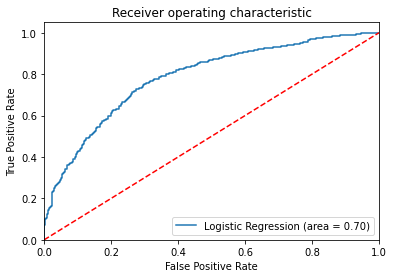

In [22]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
logit_roc_auc = roc_auc_score(test_labels, lr_clf.predict(test_features))
fpr, tpr, thresholds = roc_curve(test_labels, lr_clf.predict_proba(test_features)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()